In [34]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs

In [35]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [36]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)



    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()
    
    return fig

In [37]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [38]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [39]:
# loading data
df = pd.read_csv("WMT.csv")
df.head()

,Date,Adj Close
0,2000-01-03,44.915394
1,2000-01-04,43.234756
2,2000-01-05,42.352402
3,2000-01-06,42.814564
4,2000-01-07,46.049828


In [40]:
# Make Date a datetime object 
df['Date'] = pd.to_datetime(df['Date'])
# Make Date the index
df = df.set_index('Date')
# We have weekly data so we will set our frequency to W
df.index.freq= "B"
df.head()

,Adj Close
Date,
2000-01-03,44.915394
2000-01-04,43.234756
2000-01-05,42.352402
2000-01-06,42.814564
2000-01-07,46.049828


In [41]:
# Check for and address null values.
df.isna().sum()

Adj Close    195
dtype: int64

In [42]:
# Fill missing values with previous value
df = df.fillna(method='ffill')

In [43]:
# select data from 2010 to 2020
df = df.loc['2010':'2020']
df

,Adj Close
Date,
2010-01-01,40.374447
2010-01-04,40.963638
2010-01-05,40.555729
2010-01-06,40.465084
2010-01-07,40.487759
...,...
2020-12-25,141.253738
2020-12-28,142.946777
2020-12-29,142.041183


In [44]:
# Testing data for stationarity
get_adfuller_results(df)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,1.457409,23,2846,0.99736,0.05,False


In [45]:
# use ndiffs to determine differencing
d = ndiffs(df)
print(f'd is {d}')

d is 1


In [46]:
# Difference once
df_diff = df.diff().dropna()

In [47]:
# Testing data for stationarity
get_adfuller_results(df_diff)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-12.214006,22,2846,0.0,0.05,True


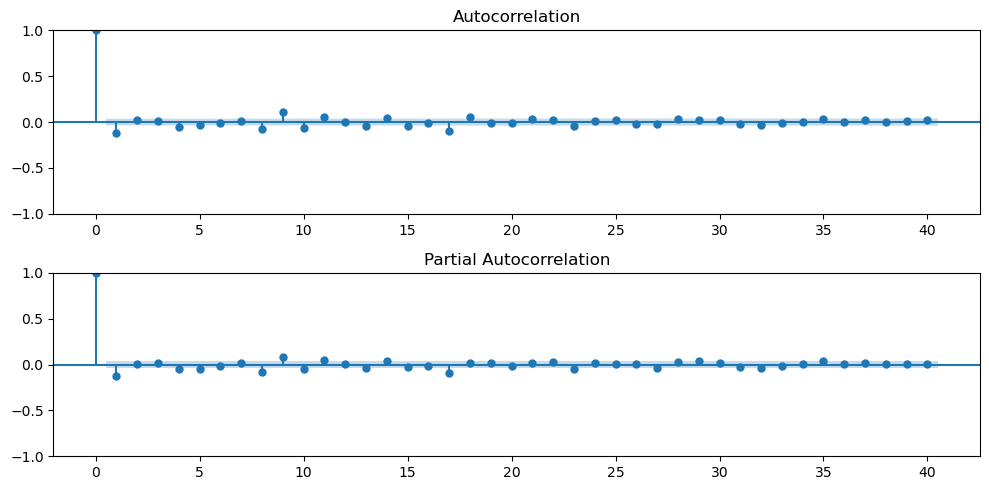

In [48]:
# Use differenced (stationary) data to plot ACF and PACF
plot_acf_pacf(df_diff);

Both ACF and PACF plots show a significant spike at lag 1 and then quickly declines.
so we will try an AR(1) model. 

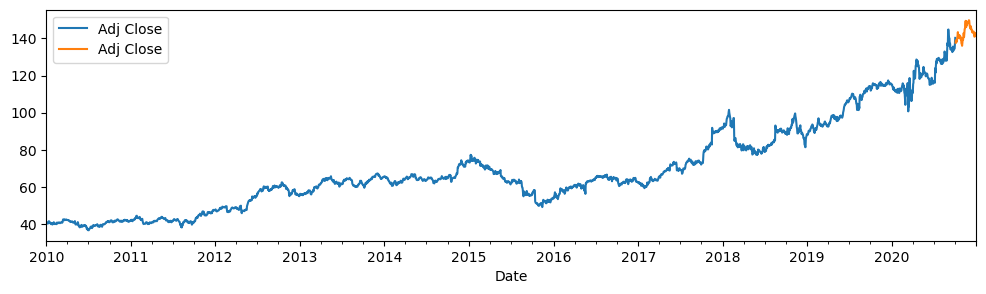

In [49]:
# Calculating number of test lags
n_test_lags = 5*13

# Modeling to predict 6 months into the future
train, test = train_test_split(df, test_size=n_test_lags)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

In [50]:
# Build the model 
p = 1  # AR component 

d = 1  # Number of differencing required to make stationary

q = 0 # MA component 

# Define and fit the model
arima_model = tsa.ARIMA(train, order=(p,d,q)).fit()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 3.769
- MSE = 22.547
- RMSE = 4.748
- R^2 = -0.753
- MAPE = 2.59%


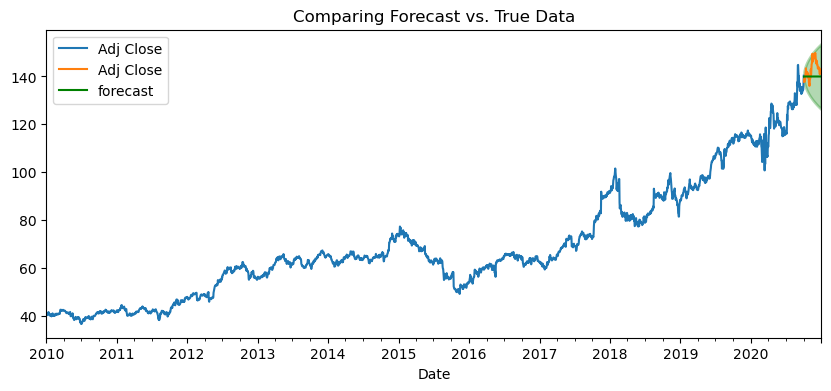

In [51]:
# Obtain summary of forecast as dataframe
forecast_df = arima_model.get_forecast(len(test)).summary_frame()

# Plot the forecast with true values
plot_forecast(train, test, forecast_df)

# Obtain metrics for evaluation.
regression_metrics_ts(test, forecast_df['mean'])

In [52]:
# Obtain summary of model
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 2805
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -3888.704
Date:                Mon, 10 Jun 2024   AIC                           7781.407
Time:                        12:48:06   BIC                           7793.285
Sample:                    01-01-2010   HQIC                          7785.694
                         - 10-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1195      0.006    -21.146      0.000      -0.131      -0.108
sigma2         0.9378      0.006    147.468      0.000       0.925       0.950
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            114589.41
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):              10.46   Skew:                             0.96
Prob(H) (two-sided):                  0.00   Kurtosis:                        34.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

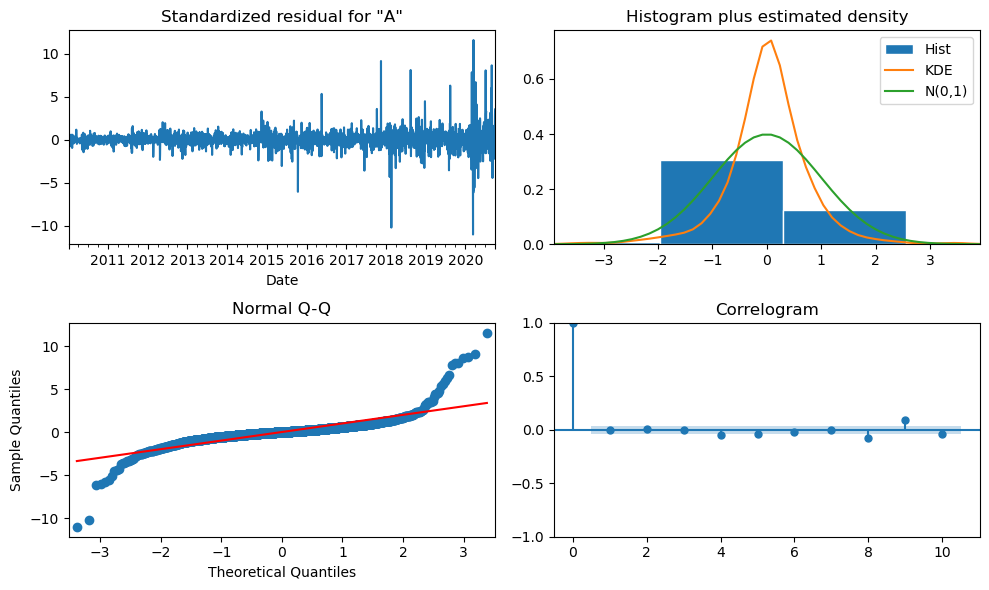

In [53]:
# Obtain diagnostic plots
fig = arima_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

There is a significant values in the correlogram of the residuals.

In [66]:
import itertools

# Define the value or range of values for p, d, q
p_values = range(0, 4)  
d_values = [1]          
q_values = range(0, 4)  

# Create combinations of pdq to test
pdq_to_try = list(itertools.product(p_values, d_values, q_values))
                                            
pdq_to_try


[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (3, 1, 0),
 (3, 1, 1),
 (3, 1, 2),
 (3, 1, 3)]

In [67]:
# define starting aic as infinity
best_aic = float("inf")  

# define baseline for pdq
best_pdq = (0,0,0)

# Loop through each combination
for pdq in pdq_to_try:
    
    model = tsa.ARIMA(train, order=pdq)
                              
    result = model.fit()
    
    print(pdq, result.aic)      
    
    # If lower, replace best AIC with new value
    if result.aic < best_aic:
        
        best_aic = result.aic
        best_pdq = pdq

# Print the best orders and AIC score
print("Best AIC:", best_aic)
print("Best pdq:", best_pdq)

(0, 1, 0) 7819.573414955272
(0, 1, 1) 7782.568450003508
(0, 1, 2) 7783.239842404125
(0, 1, 3) 7784.910104390027
(1, 1, 0) 7781.407088472942
(1, 1, 1) 7783.230521610297
(1, 1, 2) 7784.03016443745
(1, 1, 3) 7780.326580841036
(2, 1, 0) 7783.2142220706355
(2, 1, 1) 7785.212752371535


C:\Users\user\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\user\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 1, 2) 7785.389282375677
(2, 1, 3) 7771.324331833527
(3, 1, 0) 7785.193057160346
(3, 1, 1) 7787.214160907191


C:\Users\user\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\user\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\user\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 2) 7774.975880602276
(3, 1, 3) 7781.064398482802
Best AIC: 7771.324331833527
Best pdq: (2, 1, 3)


In [68]:
# Build the model with the best AIC
p = 2  # AR component 

d = 1  # Number of differencing required to make stationary

q =  3 # MA component 

# Define and fit the model
ar_2_ma_3_model = tsa.ARIMA(train, order=(p,d,q)).fit()


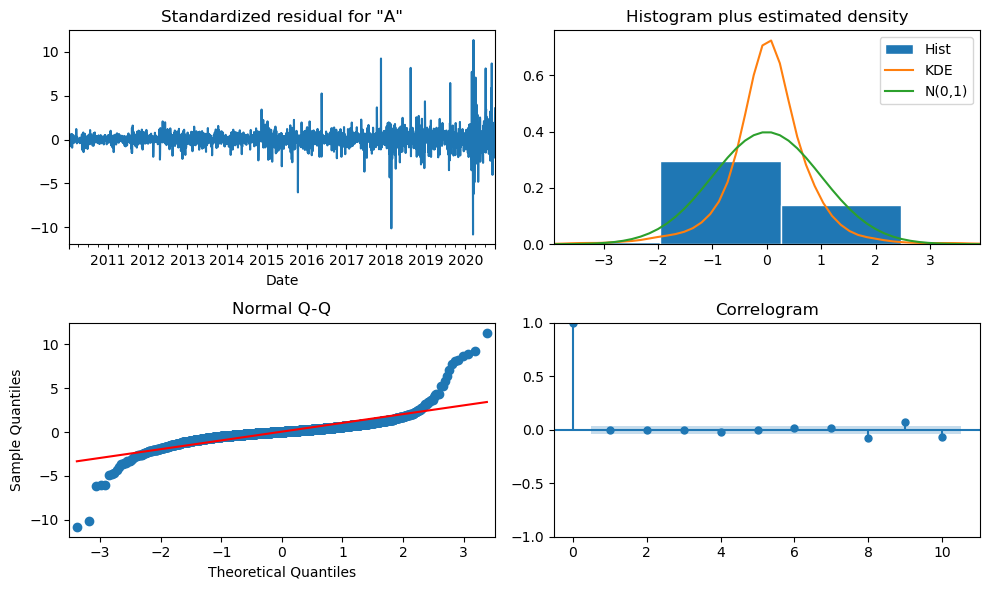

In [69]:
# Obtain diagnostic plots
fig = ar_2_ma_3_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()


The correlogram didn't improve. We will check other metrics.

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 4.144
- MSE = 26.201
- RMSE = 5.119
- R^2 = -1.037
- MAPE = 2.85%


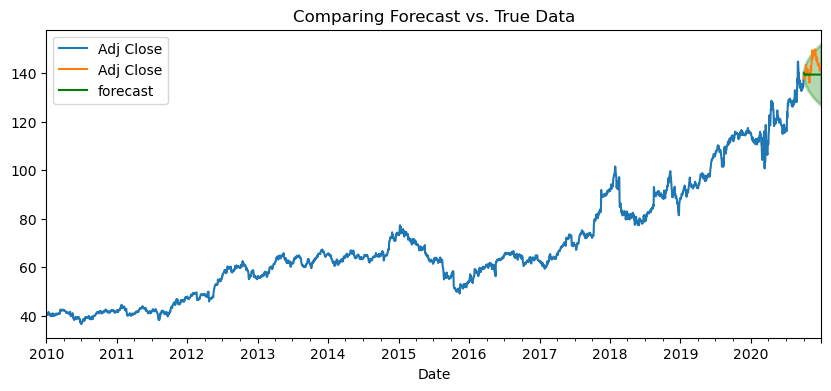

In [70]:
# Obtain summary of forecast as dataframe
forecast_df = ar_2_ma_3_model.get_forecast(len(test)).summary_frame()
# Plot the forecast with true values
plot_forecast(train, test, forecast_df)
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

In [59]:
ar_2_ma_3_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 2805
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -3879.662
Date:                Mon, 10 Jun 2024   AIC                           7771.324
Time:                        12:48:18   BIC                           7806.957
Sample:                    01-01-2010   HQIC                          7784.185
                         - 10-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5164      0.042     35.810      0.000       1.433       1.599
ar.L2         -0.8594      0.042    -20.642      0.000      -0.941      -0.778
ma.L1         -1.6399      0.044    -37.374      0.000      -1.726      -1.554
ma.L2          1.0655      0.045     23.479      0.000       0.977       1.154
ma.L3         -0.1412      0.007    -19.946      0.000      -0.155      -0.127
sigma2         0.9318      0.007    133.683      0.000       0.918       0.945
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            106820.56
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):              10.31   Skew:                             0.96
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""


initial model (1,1,0)

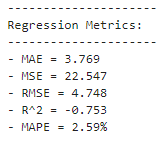
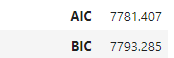

---
ARIMA model (2,1,3)

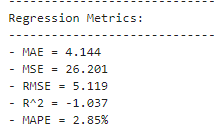
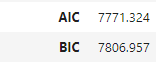

The AIC is better using the ARIMA model (2,1,3), however, the BIC and MAPE parameters are better using the model (1,1,0).

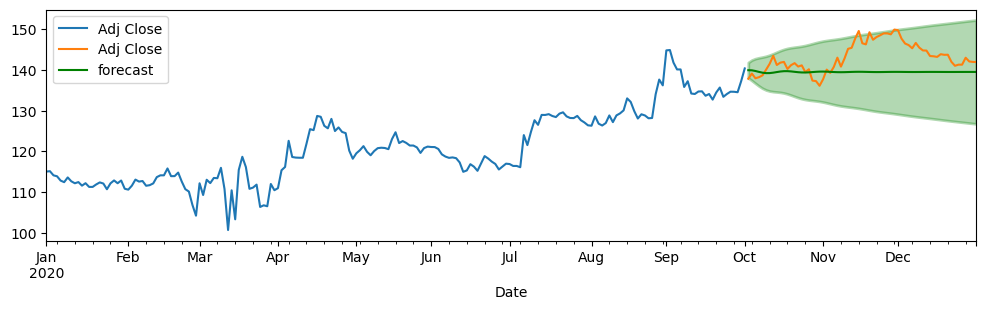

In [84]:
# select training data from 2020
train_2020 = train['2020':]


# Plot figure 
fig, ax = plt.subplots()

## Plotting Training  and test data
train.iloc[-len(train_2020):].plot(ax=ax, label="train")
test.plot(label="test", ax=ax)

## Plot forecast
forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

#{ Add the shaded confidence interval
ax.fill_between(forecast_df.index, 
forecast_df['mean_ci_lower'],
forecast_df['mean_ci_upper'],
color='green', alpha=0.3,  lw=2)

## set the title and add legend
ax.legend();

The test data have fluctuations that our model could not predict, but overall, we can see that most of the values in our test set fall within the green confidence interval of our predictions.